In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from utils.coord_utils import GreatCircleDistance, zenith_to_declination

In [2]:
df_trans = pd.read_feather('/home/hans/Projects/tensorflow/icecube_transformer/output/test_set_prediced_by_model_trans.ftr')
#df_lstm = pd.read_feather('/home/hans/Projects/tensorflow/icecube_transformer/output/test_set_prediced_by_model_lstm.ftr')

In [3]:
df = df_trans

In [4]:
df['predicted_dec'] = zenith_to_declination(df['predicted_zenith'])
df['muon_dec'] = zenith_to_declination(df['muon_zenith'])
df['ang_diff'] = GreatCircleDistance(df['muon_azimuth'], 
                                           df['muon_dec'],
                                          df['predicted_azimuth'],
                                          df['predicted_dec'])

In [5]:
np.median(np.rad2deg(df['ang_diff']))

1.0109104978926238

In [6]:
# some plotting adjustments
def adjust_plot_2d(fig, ax, pc, plot_args=None):
    if not plot_args:
        plot_args = {}
    
    pc.set_cmap(plot_args.get('cmap', 'cubehelix'))
    ax.set_ylabel(plot_args.get('ylabel', 'var 2'), position=(0., 1.), va='top', ha='right', size=20)
    ax.set_xlabel(plot_args.get('xlabel', 'var 1'), position=(1., 0.), va='bottom', ha='right', size=20)
    ax.yaxis.set_label_coords(-0.2, 1.)
    ax.xaxis.set_label_coords(1.0, -0.2)
    ax.tick_params(axis='y', which='major', labelsize=18, pad=5)
    ax.tick_params(axis='x', which='major', labelsize=18, pad=5)
    fig.subplots_adjust(right=0.78)
    cbar_ax1 = fig.add_axes([0.81, 0.1, 0.04, 0.79])
    cbar = fig.colorbar(pc, cbar_ax1)
    cbar.ax.tick_params(labelsize=18)
    cbar.set_label(plot_args.get('zlabel', 'pdf'), rotation=270, fontsize=18, labelpad=25)
    ax.set_ylim(plot_args.get('ylim', [0, 1]))
    ax.set_xlim(plot_args.get('xlim', [0, 1]))
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5)
        ax.spines[axis].set_color('0.0')
    ax.yaxis.set_ticks_position('both')

    
def adjust_plot_1d(fig, ax, plot_args=None):
    if not plot_args:
        plot_args = {}

    for axis in ['top','bottom','left','right']:
          ax.spines[axis].set_linewidth(1.5)
          ax.spines[axis].set_color('0.0')

    y_scale_in_log = plot_args.get('y_axis_in_log', False)
    if(y_scale_in_log):
        ax.set_yscale('log')

    ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=18)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel(plot_args.get('ylabel', 'pdf'), fontsize=20)
    ax.set_xlabel(plot_args.get('xlabel', 'var 1'), fontsize=20)
    ax.legend(fontsize=15, loc='upper right')
    ax.set_ylim(plot_args.get('ylim', [0, 1]))
    ax.set_xlim(plot_args.get('xlim', [0, 1]))


In [7]:
e_nu_range = [2.0, 8.0]
e_nu_bins = np.linspace(*e_nu_range, 16)
e_nu_widths = np.diff(e_nu_bins) 

dpsi_range = [0.0, 3.0]
dpsi_bins = np.linspace(*dpsi_range, 31)
dpsi_widths = np.diff(dpsi_bins)

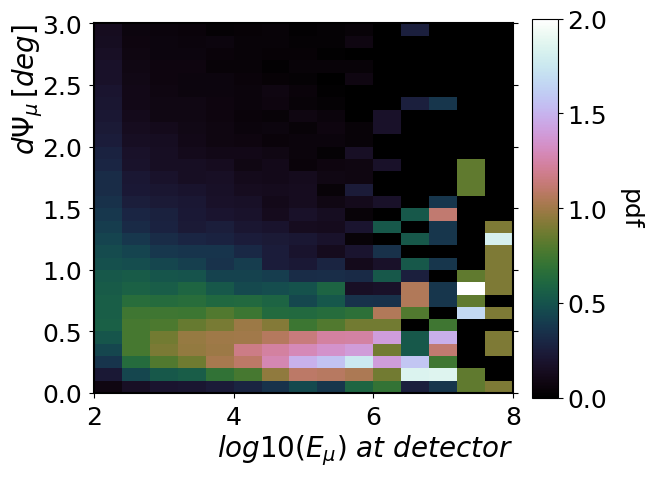

In [8]:
# now compute and plot f(Psi, Emu) from MuonGun
hist_joint_mg, _ = np.histogramdd([np.log10(df['muon_energy_at_detector']), # muon_energy on x
                                   np.rad2deg(df['ang_diff'])], # delta_angle on y
                                  bins=[e_nu_bins, dpsi_bins],
                                  density=True)

# convert from f(Psi, Emu) to f(Psi | Emu) by conditioning
# and plot again

hist_marginal_mg = np.sum(hist_joint_mg, axis=1, keepdims=True) * dpsi_widths
hist_cond_mg = hist_joint_mg / hist_marginal_mg

fig, ax = plt.subplots()
X, Y = np.meshgrid(e_nu_bins, dpsi_bins)

pc = ax.pcolormesh(X, Y, hist_cond_mg.T, norm=matplotlib.colors.Normalize(vmin=0.0, vmax=2))
plot_args = {'xlim': e_nu_range, 'ylim': dpsi_range, \
             'xlabel':'$log10(E_{\\mu})\,\,at\,\,detector$',
             'ylabel':'$d\\Psi_\\mu\,[deg]$'}
adjust_plot_2d(fig, ax, pc, plot_args=plot_args) # some formatting.
plt.show()

In [9]:
def get_quantiles(dpsi, energy, e_bins):
    lower, med, upper = [], [], []
    for el, eh in zip(e_bins[:-1], e_bins[1:]):
        print(el, eh)
        idx = np.logical_and(energy >= el, energy < eh)
        l, m, u = np.percentile(dpsi[idx], [10, 50, 90])
        lower.append(l)
        med.append(m)
        upper.append(u)
        
    return lower, med, upper

In [10]:
lower, med, upper = get_quantiles(df['ang_diff'], np.log10(df['muon_energy_at_detector']), e_nu_bins)

2.0 2.4
2.4 2.8
2.8 3.2
3.2 3.6
3.6 4.0
4.0 4.4
4.4 4.800000000000001
4.800000000000001 5.2
5.2 5.6
5.6 6.0
6.0 6.4
6.4 6.800000000000001
6.800000000000001 7.2
7.2 7.6000000000000005
7.6000000000000005 8.0


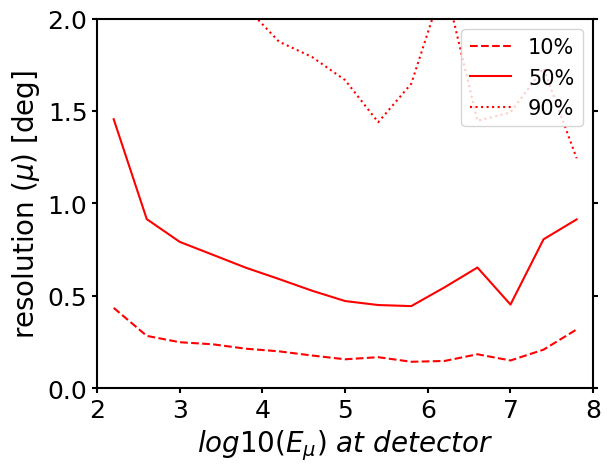

In [11]:
centers = lambda x: 0.5 * (x[:-1]+x[1:])
e_nu_centers = centers(e_nu_bins)
fig, ax = plt.subplots()
plot_args = {'xlabel':'$log10(E_{\\mu})\,\,at\,\,detector$', 
             'ylabel':'resolution ($\mu$) [deg]', 
             'xlim':[2.0, 8.0], 
             'ylim':[0.0, 2.0]}

ax.plot(e_nu_centers, np.rad2deg(lower), color='red', label='10%', linestyle='dashed')
ax.plot(e_nu_centers, np.rad2deg(med), color='red', label='50%')
ax.plot(e_nu_centers, np.rad2deg(upper), color='red', label='90%', linestyle='dotted')
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.show()

/tmp/ipykernel_4831/526250705.py:43: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(plot_args.get('ylim', [0, 1]))


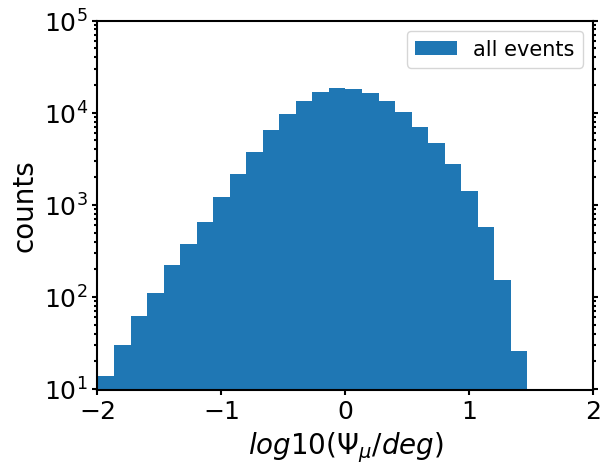

In [12]:
fig, ax = plt.subplots()
psi_bins = np.linspace(-2, 2, 31)

plot_args = {'xlabel':'$log10(\Psi_\mu/deg)$', 
             'ylabel':'counts', 
             'xlim':[-2, 2], 
             'ylim':[0.0, 1.e5],
             'y_axis_in_log': True}

ax.hist(np.log10(np.rad2deg(df['ang_diff'])), bins=psi_bins, label='all events')
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.show()

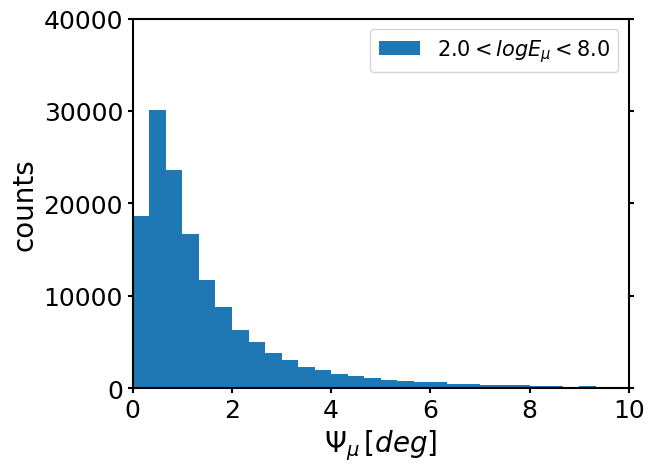

In [13]:
low = 100
high = 1.e8

fig, ax = plt.subplots()
psi_bins = np.linspace(0.0, 10.0, 31)

plot_args = {'xlabel':'$\Psi_\mu\,[deg]$', 
             'ylabel':'counts', 
             'xlim':[0.0, 10.0], 
             'ylim':[0.0, 4.e4],
             'y_axis_in_log': False}

idx = df['muon_energy'] > low
idx = np.logical_and(idx, df['muon_energy'] < high)
ax.hist(np.rad2deg(df[idx]['ang_diff']), bins=psi_bins, label=f'${np.log10(low)} < logE_\mu < {np.log10(high)}$')
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.show()

/tmp/ipykernel_4831/526250705.py:43: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(plot_args.get('ylim', [0, 1]))


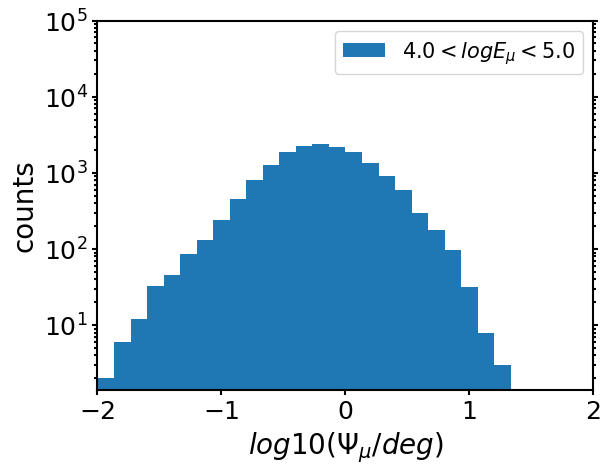

In [14]:
low = 1.e4
high = 1.e5

fig, ax = plt.subplots()
psi_bins = np.linspace(-2, 2, 31)

plot_args = {'xlabel':'$log10(\Psi_\mu/deg)$', 
             'ylabel':'counts', 
             'xlim':[-2, 2], 
             'ylim':[0.0, 1.e5],
             'y_axis_in_log': True}

idx = df['muon_energy'] > low
idx = np.logical_and(idx, df['muon_energy'] < high)
ax.hist(np.log10(np.rad2deg(df[idx]['ang_diff'])), bins=psi_bins, label=f'${np.log10(low)} < logE_\mu < {np.log10(high)}$')
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.show()

/tmp/ipykernel_4831/526250705.py:43: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(plot_args.get('ylim', [0, 1]))


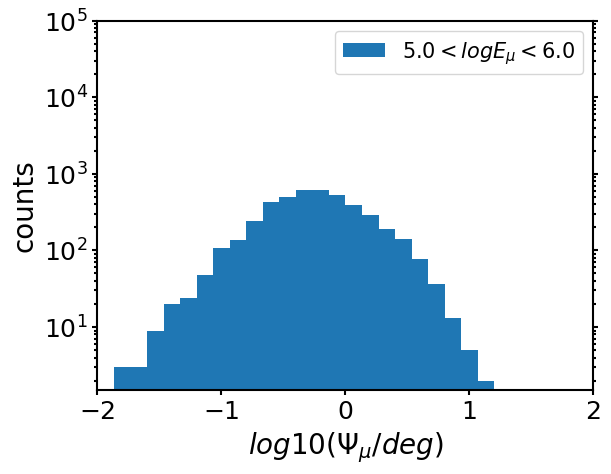

In [15]:
low = 1.e5
high = 1.e6

fig, ax = plt.subplots()
psi_bins = np.linspace(-2, 2, 31)

plot_args = {'xlabel':'$log10(\Psi_\mu/deg)$', 
             'ylabel':'counts', 
             'xlim':[-2, 2], 
             'ylim':[0.0, 1.e5],
             'y_axis_in_log': True}

idx = df['muon_energy'] > low
idx = np.logical_and(idx, df['muon_energy'] < high)
ax.hist(np.log10(np.rad2deg(df[idx]['ang_diff'])), bins=psi_bins, label=f'${np.log10(low)} < logE_\mu < {np.log10(high)}$')
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.show()

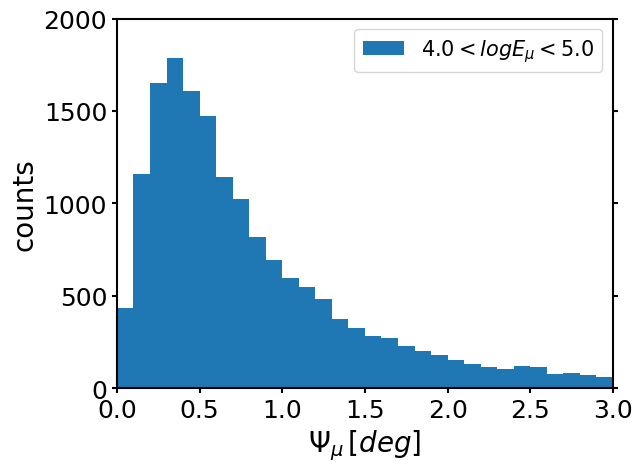

In [16]:
low = 1.e4
high = 1.e5

fig, ax = plt.subplots()
psi_bins = np.linspace(0.0, 3.0, 31)

plot_args = {'xlabel':'$\Psi_\mu\,[deg]$', 
             'ylabel':'counts', 
             'xlim':[0.0, 3.0], 
             'ylim':[0.0, 2.e3],
             'y_axis_in_log': False}

idx = df['muon_energy'] > low
idx = np.logical_and(idx, df['muon_energy'] < high)
ax.hist(np.rad2deg(df[idx]['ang_diff']), bins=psi_bins, label=f'${np.log10(low)} < logE_\mu < {np.log10(high)}$')
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.show()

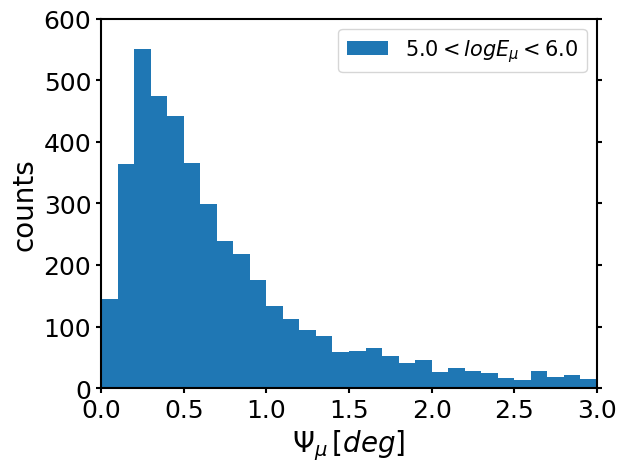

In [17]:
low = 1.e5
high = 1.e6

fig, ax = plt.subplots()
psi_bins = np.linspace(0.0, 3.0, 31)

plot_args = {'xlabel':'$\Psi_\mu\,[deg]$', 
             'ylabel':'counts', 
             'xlim':[0.0, 3.0], 
             'ylim':[0.0, 6.e2],
             'y_axis_in_log': False}

idx = df['muon_energy'] > low
idx = np.logical_and(idx, df['muon_energy'] < high)
ax.hist(np.rad2deg(df[idx]['ang_diff']), bins=psi_bins, label=f'${np.log10(low)} < logE_\mu < {np.log10(high)}$')
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.show()

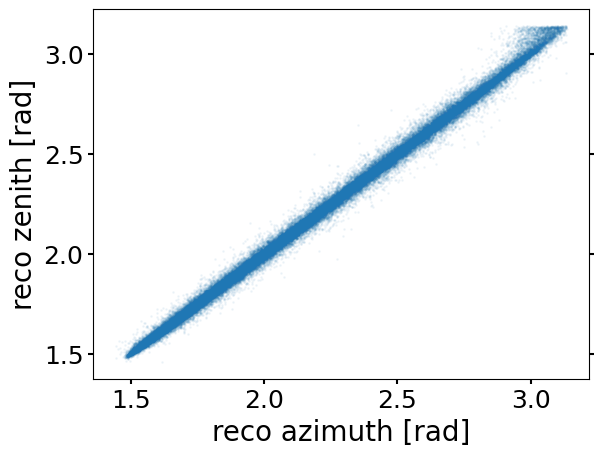

In [18]:
fig, ax = plt.subplots()
ax.scatter(df['muon_zenith'], df['predicted_zenith'], s=1, alpha=0.05)
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=18)
ax.yaxis.set_ticks_position('both')
ax.set_ylabel('reco zenith [rad]', fontsize=20)
ax.set_xlabel('reco azimuth [rad]', fontsize=20)
    
plt.show()

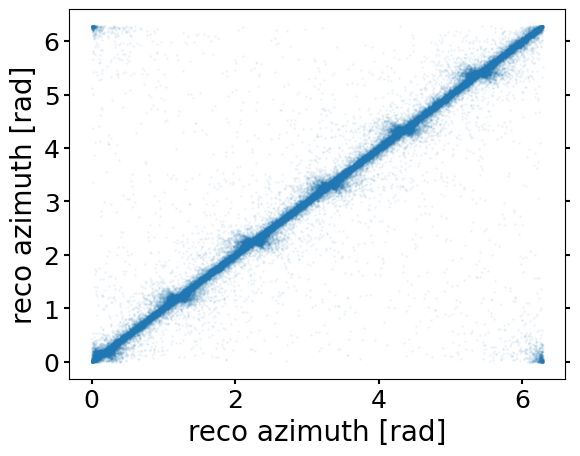

In [19]:
fig, ax = plt.subplots()
ax.scatter(df['muon_azimuth'], df['predicted_azimuth'], s=1, alpha=0.05)
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=18)
ax.yaxis.set_ticks_position('both')
ax.set_ylabel('reco azimuth [rad]', fontsize=20)
ax.set_xlabel('reco azimuth [rad]', fontsize=20)
    
plt.show()

2.0 2.4
2.4 2.8
2.8 3.2
3.2 3.6
3.6 4.0
4.0 4.4
4.4 4.800000000000001
4.800000000000001 5.2
5.2 5.6
5.6 6.0
6.0 6.4
6.4 6.800000000000001
6.800000000000001 7.2
7.2 7.6000000000000005
7.6000000000000005 8.0


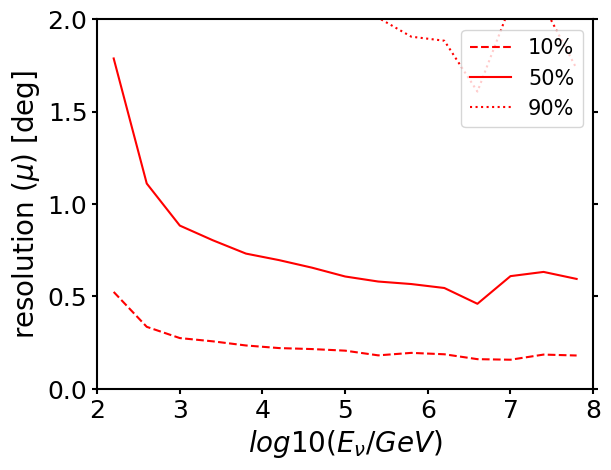

In [20]:
lower, med, upper = get_quantiles(df['ang_diff'], np.log10(df['neutrino_energy']), e_nu_bins)

centers = lambda x: 0.5 * (x[:-1]+x[1:])
e_nu_centers = centers(e_nu_bins)
fig, ax = plt.subplots()
plot_args = {'xlabel':'$log10(E_{\\nu}/GeV)$', 
             'ylabel':'resolution ($\mu$) [deg]', 
             'xlim':[2.0, 8.0], 
             'ylim':[0.0, 2.0]}

ax.plot(e_nu_centers, np.rad2deg(lower), color='red', label='10%', linestyle='dashed')
ax.plot(e_nu_centers, np.rad2deg(med), color='red', label='50%')
ax.plot(e_nu_centers, np.rad2deg(upper), color='red', label='90%', linestyle='dotted')
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.show()

In [21]:
! ls

apply_model_to_testdata.py
apply_to_testset.ipynb
backup
backup_lstm
benchmark.py
best_angdist_zoom.png
best_azimuth.png
best_benchmark.py
best_zenith.png
concat_tfrecords.py
convert_datasets_ftr_to_tfrecords_by_directory.py
convert_datasets_i3_to_ftr_by_directory_oldsets.py
convert_datasets_i3_to_ftr_by_directory.py
convert_ftr_tfrecord_dom_based.py
convert_i3_ftr.py
data
experiment_with_ragged_tensors_cpy.ipynb
explore_variables.ipynb
find_nan_record.ipynb
generate_testset_tf_records_by_seq_len.py
get_weights_from_auto_checkpoint.ipynb
get_weights_from_auto_checkpoint_lstm.ipynb
lstm_baseline.py
lstm_residual.py
models
nohup.out
npulses_distribution.ipynb
npulses_distribution_small.ipynb
old_shard_tfrecords_parallel2.py
__pycache__
resolution.ipynb
resolution_lstm.ipynb
results.ipynb
run2.out
run.out
shard_tfrecords_parallel.py
shard_tfrecords.py
study_n_channel.ipynb
test2.png
test3.png
test_gradient_accumulation.ipynb
testing_seqpool_layer.ipynb
test.png
tmp2.py
tmp.py
train2.py
tr

In [24]:
scores = pd.read_csv("train_trans.log", names=["step", "train_score", "test_score"])

    step  train_score  test_score
0      0     0.057026    0.040196
1      1     0.041324    0.039865
2      2     0.038104    0.036693
3      3     0.034991    0.032799
4      4     0.033539    0.031579
5      5     0.033070    0.030505
6      6     0.032609    0.031347
7      7     0.032072    0.030113
8      8     0.031832    0.029916
9      9     0.031303    0.029347
10    10     0.031024    0.029260
11    11     0.031178    0.028890
12    12     0.031188    0.028756
13    13     0.030696    0.028943
14    14     0.031138    0.029069
15    15     0.030695    0.028543
16    16     0.030698    0.028687
17    17     0.030671    0.028551


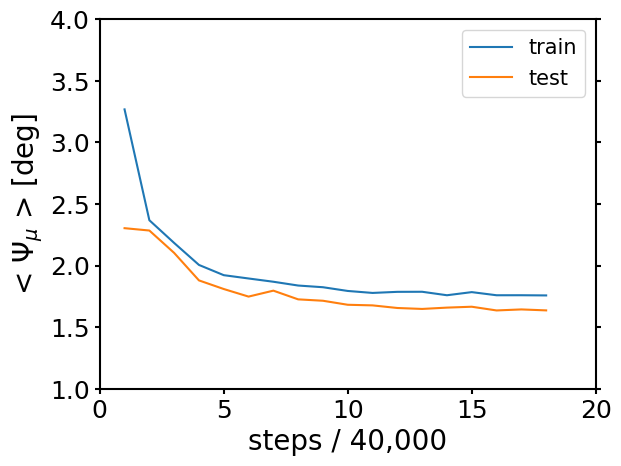

In [32]:
fig, ax = plt.subplots()

plot_args = {'xlabel':'steps / 40,000', 
             'ylabel':'< $\Psi_\mu$ > [deg]', 
             'xlim':[0.0, 20.0], 
             'ylim':[1.0, 4.0],
             'y_axis_in_log': False}

ax.plot(scores['step']+1, np.rad2deg(scores['train_score']), label='train')
ax.plot(scores['step']+1, np.rad2deg(scores['test_score']), label='test')
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.show()